In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [4]:
# データ準備
fish_parray = pd.read_csv("../data/3-8-1-fish-num-1.csv")
fish_df = pd.DataFrame(fish_parray)

print(fish_df.shape)
display(fish_df.head())

(100, 3)


,fish_num,weather,temperature
0,0,cloudy,5.5
1,2,cloudy,21.1
2,5,cloudy,17.2
3,1,cloudy,5.0
4,3,cloudy,28.3


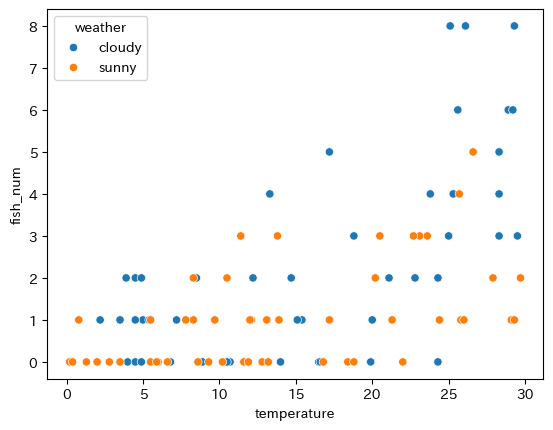

In [5]:
# データの可視化
fig, ax = plt.subplots()
ax = sns.scatterplot(x = fish_parray["temperature"], y = fish_parray["fish_num"],
                     hue = fish_parray["weather"])

In [6]:
# データの準備
y = fish_parray["fish_num"].values
X_dum_df = pd.get_dummies(fish_df.drop("fish_num", axis=1), dtype=int, drop_first=True)
col_li = X_dum_df.columns # 説明変数の次元指定用に取得
X = X_dum_df.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(100,)
[0 2 5 1 3 5 2 3 0 0]
(100, 2)
[[ 5.5  0. ]
 [21.1  0. ]
 [17.2  0. ]
 [ 5.   0. ]
 [28.3  0. ]
 [28.3  0. ]
 [ 3.9  0. ]
 [25.   0. ]
 [14.   0. ]
 [16.5  0. ]]
Index(['temperature', 'weather_sunny'], dtype='object')


## ベイズ推論

In [7]:
# # 確率モデルの定義
# model = pm.Model(coords={"predictors":col_li})

# with model:
#     # 観測値をConstantDataとして定義
#     y_data = pm.Data("y_data", y, mutable=True)
#     X_data = pm.Data("X_data", X.T, mutable=True)

#     # パラメータを確率変数として定義
#     b0 = pm.Normal("b0", mu=0, sigma=10000)
#     b = pm.Normal("b", mu=0, sigma=10000, dims="predictors")

#     # 目的変数の期待値を確率変数として定義
#     exp_lambda_ = pm.Deterministic("exp_lambda_", pt.exp(b @ X_data + b0))

#     # 観測値を持つ確率変数として定義
#     y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

# g = pm.model_to_graphviz(model)
# display(g)

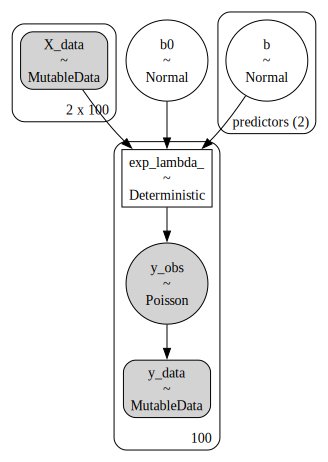

In [8]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X.T, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors")

    # 目的変数の期待値を確率変数として定義
    exp_lambda_ = pm.Deterministic("exp_lambda_", pt.exp(b @ X_data + b0))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [9]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 44 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


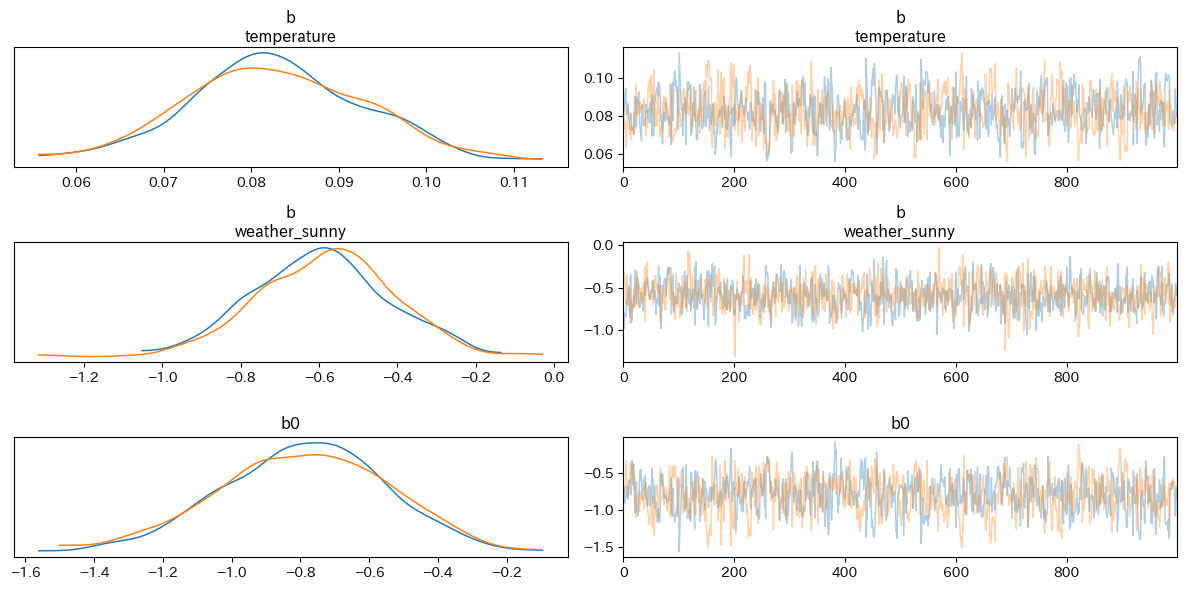

In [10]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0"])
plt.tight_layout();

In [11]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[temperature],0.083,0.010,0.063,0.101,0.000,0.000,541.0,593.0,1.0
b[weather_sunny],-0.590,0.172,-0.886,-0.248,0.006,0.004,926.0,1019.0,1.0
b0,-0.793,0.239,-1.235,-0.338,0.011,0.008,526.0,639.0,1.0


## ポアソン回帰曲線の描画(釣獲尾数の期待値の分布)

### Deterministicに持っているデータで描画

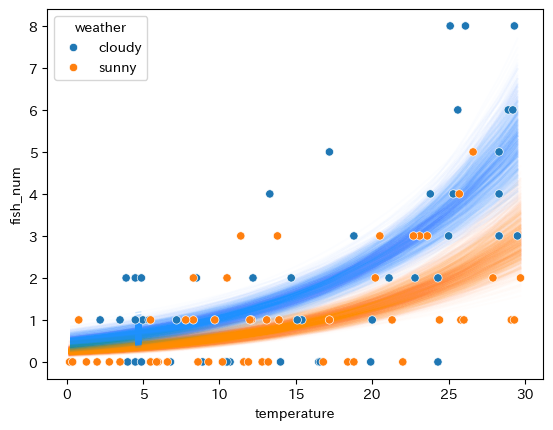

In [12]:
# 各天気における温度のデータを取得
sunny_t = fish_df[fish_df["weather"]=="sunny"]["temperature"]
cloudy_t = fish_df[fish_df["weather"]=="cloudy"]["temperature"]

# サンプリング結果から釣獲尾数の期待値を取得
y_preds = idata1["posterior"]["exp_lambda_"][0].values

# y_predsから各天気の値に対応するインデックスを取得
sunny_index = fish_df[fish_df["weather"]=="sunny"].index.tolist()
cloudy_index = fish_df[fish_df["weather"]=="cloudy"].index.tolist()

# 晴れのポアソン回帰曲線
for i in range(y_preds.shape[0]):
    sunny_y_preds = y_preds[i][sunny_index]
    sns.lineplot(x=sunny_t, y=sunny_y_preds, color="darkorange", alpha=0.01, zorder=1)

# 曇りのポアソン回帰曲線
for i in range(y_preds.shape[0]):
    cloudy_y_preds = y_preds[i][cloudy_index]
    sns.lineplot(x=cloudy_t, y=cloudy_y_preds, color="dodgerblue", alpha=0.01, zorder=1)

# 観測データの散布図
ax = sns.scatterplot(x = fish_parray["temperature"], y = fish_parray["fish_num"],
                     hue = fish_parray["weather"], zorder=2)

### パラメータを抽出して、算出・描画

In [13]:
# サンプリング結果からパラメータ抽出
b_ifr = idata1["posterior"]["b"][0].values.reshape(-1, 2)
b0_ifr = idata1["posterior"]["b0"][0].values.reshape(-1, 1)

print(b_ifr, b_ifr.shape)
print(b0_ifr, b0_ifr.shape)

[[ 0.08146691 -0.79593733]
 [ 0.08004311 -0.79095326]
 [ 0.08377657 -0.97881178]
 ...
 [ 0.08503458 -0.51191911]
 [ 0.07948526 -0.59563985]
 [ 0.08557072 -0.55913581]] (1000, 2)
[[-0.68531376]
 [-0.77369614]
 [-0.69508364]
 [-0.90522534]
 [-0.85282583]
 [-0.82473592]
 [-0.67944027]
 [-0.67693597]
 [-0.80721361]
 [-0.85484131]
 [-0.76787772]
 [-0.59065021]
 [-0.60035401]
 [-0.69755201]
 [-0.79791168]
 [-0.41425833]
 [-0.33318138]
 [-0.6623706 ]
 [-0.65265075]
 [-0.3791317 ]
 [-0.62084467]
 [-1.01839966]
 [-1.03684411]
 [-0.96718088]
 [-0.62135625]
 [-1.00207192]
 [-1.0328898 ]
 [-1.07559203]
 [-0.91239739]
 [-0.71636906]
 [-0.46430975]
 [-0.59605241]
 [-0.45305836]
 [-0.57672482]
 [-0.75244173]
 [-0.86390855]
 [-0.7096657 ]
 [-0.58126602]
 [-0.60892687]
 [-0.80306265]
 [-0.53744721]
 [-0.81392355]
 [-0.86986714]
 [-0.94368399]
 [-0.93599326]
 [-0.78797928]
 [-0.67176781]
 [-0.73034053]
 [-0.94432567]
 [-0.7153134 ]
 [-0.67600066]
 [-0.8758691 ]
 [-0.43436329]
 [-0.90965758]
 [-0.5835495

In [14]:
# 説明変数としての入力データを用意
t_min = X_dum_df["temperature"].min()
t_max = X_dum_df["temperature"].max()
plot_num = 10

# 各配列作成
t_data =  np.linspace(t_min, t_max, plot_num)
sunny_data = np.full(plot_num, 1)
cloudy_data = np.full(plot_num, 0)

x_sunny_array = np.array([t_data, 
                          sunny_data]) # 晴れの時の説明変数
x_cloudy_array = np.array([t_data, 
                           cloudy_data]) # 曇りの時の説明変数

print(x_sunny_array, x_sunny_array.shape)

[[ 0.2         3.47777778  6.75555556 10.03333333 13.31111111 16.58888889
  19.86666667 23.14444444 26.42222222 29.7       ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]] (2, 10)


In [15]:
# 釣獲尾数の期待値

# 強度の計算
lambda_sunny = b_ifr @ x_sunny_array + b0_ifr
lambda_cloudy = b_ifr @ x_cloudy_array + b0_ifr

# 期待値を計算
e_sunny = np.exp(lambda_sunny)
e_cloudy = np.exp(lambda_cloudy)

print(e_sunny, e_sunny.shape)

[[0.23108776 0.30181915 0.39420002 ... 1.49818641 1.95675159 2.5556745 ]
 [0.21253666 0.27629746 0.35918643 ... 1.33362921 1.7337167  2.25383006]
 [0.19068354 0.25094058 0.33023917 ... 1.3035181  1.71543695 2.25752442]
 ...
 [0.27562777 0.36422644 0.48130454 ... 1.93937769 2.56277739 3.38656466]
 [0.28493035 0.3697325  0.47977382 ... 1.76514797 2.29049861 2.97220628]
 [0.26214582 0.3470201  0.45937391 ... 1.86734609 2.47193196 3.27226307]] (1000, 10)


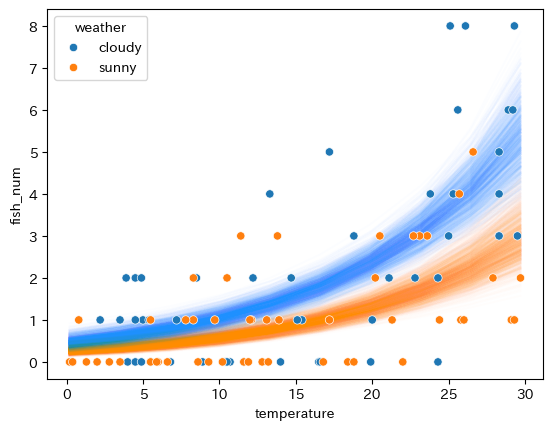

In [16]:
# 描画
fig, ax = plt.subplots()

# 晴れの時のポアソン回帰曲線
for y_pred in e_sunny:
    sns.lineplot(x=t_data, y=y_pred, color="darkorange", alpha=0.01, zorder=1)

# 晴れの時のポアソン回帰曲線
for y_pred in e_cloudy:
    sns.lineplot(x=t_data, y=y_pred, color="dodgerblue", alpha=0.01, zorder=1)

# 観測データの散布図
ax = sns.scatterplot(x = fish_parray["temperature"], y = fish_parray["fish_num"],
                     hue = fish_parray["weather"], zorder=2)